# Getting Startted with GRN inference using diffusion model

Diffusion model has been widely used in generative AI, especially in the vision domain. In our paper, we proposed RegDiffusion, a diffusion based model for GRN inference. Compared with previous model, RegDiffusion completes inference within a fraction of time and yield better benchmarking results. 

In this tutorial, we provide an example of running GRN inference using RegDiffusion and generating biological insights from the inferred network. 

## Requirements

We will need the python package `regdiffusion` for GRN inference. For accelerated inference speed, you may want to run `regdiffusion` on GPU devices with the latest CUDA installation. 

For network visualization and interpretation, we will need `networkx` and `pyvis`. 

```
pip install regdiffusion, networkx, pyvis
```

In [1]:
import regdiffusion as rd
import numpy as np

import networkx as nx
from pyvis import network as net

## Data loading

The input of `regdiffusion` is simply a single-cell gene expression matrix, where the columns are genes and rows are cells. We expect you to log transform your data. RegDiffusion is capable to infer GRNs among 10,000+ genes (depending on GPU hardware) within minutes so there is no need to apply heavy gene filtering. The only genes you may want to remove are genes that are not expressed at all (total raw count on all cells == 0). 

The `regdiffusion` package comes with a set of preprocessed data, including the [BEELINE benchmarks](https://pubmed.ncbi.nlm.nih.gov/31907445/), [Hammond microglia](https://pubmed.ncbi.nlm.nih.gov/30471926/) in male adult mice, and another labelled microglia subset from a [mice cerebellum atlas project](https://singlecell.broadinstitute.org/single_cell/study/SCP795/a-transcriptomic-atlas-of-the-mouse-cerebellum#study-summary). 

Here we use the `mESC` data from the BEELINE benchmark. The `mESC` data comes from [Mouse embryonic stem cells](https://www.nature.com/articles/s41467-018-02866-0). It has 421 cells and 1,620 genes. 

If you want to see the inference on a larger network with 14,000+ genes and 8,000+ cells, check out the other example. 

In [6]:
bl_dt, bl_gt = rd.data.load_beeline(
    benchmark_data='mESC', benchmark_setting='1000_STRING'
)

Here, `load_beeline` gives you a tuple, where the first element is an anndata of the single cell experession data and the second element is an array of all the ground truth links (based on the STRING network in this case). 

In [4]:
bl_dt

AnnData object with n_obs × n_vars = 421 × 1620
    obs: 'cell_type', 'cell_type_index'

In [5]:
bl_gt

array([['KLF6', 'JUN'],
       ['JUN', 'KLF6'],
       ['KLF6', 'ATF3'],
       ...,
       ['SIN3A', 'TET1'],
       ['MEF2C', 'TCF12'],
       ['TCF12', 'MEF2C']], dtype=object)

In [ ]:
rd_trainer = rd.RegDiffusionTrainer(bl_dt.X, compile=False)
rd_trainer.train()
evaluator = rd.evaluator.GRNEvaluator(bl_gt, bl_dt.var_names)
evaluator.evaluate(rd_trainer.get_adj())

In [32]:
grn = rd_trainer.generate_grn(bl_dt.var_names)
adj_table = grn.extract_node_2hop_neighborhood('HIST1H1D', k=40)
adj_table.weight = adj_table.weight.map(lambda x: [3, 1, 0.5][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


In [55]:
import networkx as nx

adj_table = grn.extract_node_2hop_neighborhood('HIST1H1D', 40)
adj_table.weight = adj_table.weight.map(lambda x: [3, 1, 0.5][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
# Create a graph
G = adj_nx

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Sort nodes based on betweenness centrality
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Remove edges with highest betweenness centrality
num_edges_to_remove = len(G.edges()) // 8 # Remove 1/3 of edges
edges_to_remove = []
for node1, node2 in sorted(G.edges(), key=lambda x: betweenness_centrality[x[0]] + betweenness_centrality[x[1]], reverse=True)[:num_edges_to_remove]:
    edges_to_remove.append((node1, node2))

G.remove_edges_from(edges_to_remove)

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print the clusters
print("Clusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {list(cluster)}")

Clusters:
Cluster 1: ['ABTB1', 'UHRF1', 'GM10184', 'KNTC1', 'MCM7', 'TAF1', 'RAD54B', 'MCM10', 'FBXO5', 'RRM2', 'ZFP367', 'RBBP4', 'HIST1H2AF', 'TOP2A', 'TIMELESS', 'HIST1H1A', 'EGR1', 'PCNA', 'MAZ', 'HIST1H2BB', 'DNMT1', 'HIST1H2AC', 'BARD1', 'H1F0', 'HIST1H2BN', 'HIST1H2AI', 'HIST1H2BK', 'ATF4', 'HIST1H3H', 'HIST1H2BF', 'DEK', 'MCM6', 'HIST1H2AG', 'MCM4', 'BRCA1', 'HIST1H1B', 'RAD51', 'RANBP17', 'HIST1H2AK', 'MCM5', 'HIST1H4K', 'GM26448', 'HIST1H2BL', 'POLR3B', 'E2F1', 'HIST1H1D', 'MCM3']
Cluster 2: ['GM44335']
Cluster 3: ['KANK3']


In [64]:
import networkx as nx
from sklearn.cluster import KMeans
from node2vec import Node2Vec

# Create a graph
adj_table = grn.extract_node_2hop_neighborhood('HIST1H1D', 40)
adj_table.weight = adj_table.weight.map(lambda x: [3, 1, 0.5][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
# Create a graph
G = adj_nx

# Learn node embeddings using Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get the node embeddings
node_embeddings = [model.wv.get_vector(str(node)) for node in G.nodes()]

# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(node_embeddings)
node_labels = kmeans.labels_

# Print the clusters
print("Clusters:")
for cluster_id in range(max(node_labels) + 1):
    cluster_nodes = [node for node, label in zip(G.nodes(), node_labels) if label == cluster_id]
    print(f"Cluster {cluster_id}: {','.join(cluster_nodes)}")

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 158.20it/s]


Clusters:
Cluster 0: RAD51,RRM2,MCM10,UHRF1,PCNA,E2F1,TIMELESS,BARD1,MCM6,MCM5,MCM4,RBBP4,MCM3,ZFP367,MCM7
Cluster 1: GM44335,TOP2A,POLR3B,GM10184,H1F0,KANK3,ATF4,MAZ
Cluster 2: HIST1H2BL,HIST1H1D,HIST1H2AC,HIST1H1B,HIST1H2BN,HIST1H1A,HIST1H4K,HIST1H2BK,HIST1H2AK,HIST1H2BF,HIST1H3H,HIST1H2AF,HIST1H2AI,HIST1H2AG,HIST1H2BB,DNMT1,FBXO5,KNTC1,RAD54B,BRCA1,ABTB1,TAF1,RANBP17,DEK
Cluster 3: GM26448,EGR1


/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


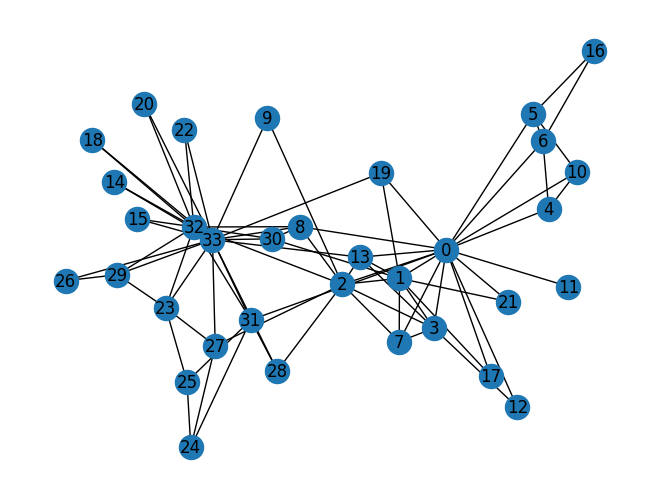

In [37]:
# Optionally, visualize the final graph
G = nx.karate_club_graph()

nx.draw(G, with_labels=True)
plt.show()

In [23]:
starting_edge = np.unravel_index(grn.adj_matrix.argmax(), grn.adj_matrix.shape)

In [24]:
all_sources = []
all_targets = []
for i in range(len(grn.gene_names)):
    all_sources.append(
        grn.extract_node_sources(grn.gene_names[i], 20, return_raw_indices=True)['tf_indices']
    )
for i in range(len(grn.tf_names)):
    all_targets.append(
        grn.extract_node_targets(grn.tf_names[i], 20, return_raw_indices=True)['gene_indices']
    )

In [25]:
grn.extract_node_sources(grn.gene_names[starting_edge[0]], 20, return_raw_indices=True)

{'tf_indices': array([1068, 1557,  721, 1476,  684,  665, 1216,  556,  299, 1347,  345,
        1037,  970,  143,  505,  122,  892,  497,  493,  864]),
 'weights': array([ 7.37 ,  7.492,  7.64 ,  7.824,  9.1  , 15.94 , 15.586, 14.45 ,
        14.29 , 15.664, 14.98 , 15.56 , 15.4  ,  7.83 , 12.59 , 15.1  ,
        13.516, 15.35 , 15.16 , 15.34 ], dtype=float16)}

(array([2858, 2859, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902,
        5903, 5904, 5905, 5906, 5907]),)

In [44]:
bl_gt[np.where((bl_gt == 'HIST1H1D').sum(1) != 0),]

array([[['RB1', 'HIST1H1D'],
        ['HIST1H1D', 'RB1'],
        ['HIST1H1D', 'HMGB2'],
        ['HMGB2', 'HIST1H1D'],
        ['HIST1H1D', 'H1F0'],
        ['H1F0', 'HIST1H1D'],
        ['HIST1H1D', 'HIST1H1B'],
        ['HIST1H1B', 'HIST1H1D'],
        ['HIST1H1D', 'EP400'],
        ['EP400', 'HIST1H1D'],
        ['HIST1H1D', 'HMGA2'],
        ['HMGA2', 'HIST1H1D'],
        ['HIST1H1D', 'HIST1H1A'],
        ['HIST1H1D', 'TRP53'],
        ['TRP53', 'HIST1H1D'],
        ['HIST1H1D', 'HIST1H4K']]], dtype=object)

In [ ]:
bl_g,]

In [53]:
adj_table = grn.extract_node_2hop_neighborhood('HIST1H1D', 40)
adj_table.weight = adj_table.weight.map(lambda x: [3, 1, 0.5][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


In [26]:
grn.gene_names[starting_edge[0]]

'HIST1H1D'

<Axes: ylabel='Count'>

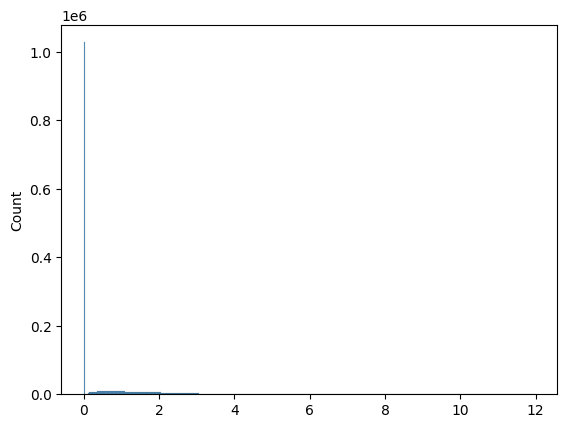

In [60]:
sns.histplot(adj.flatten())

In [7]:
np.sum(np.abs(adj) > 0.1) / adj.shape[0] / adj.shape[0] 

0.5324218392295718

In [20]:
cb_microglia = rd.data.load_atlas_microglia()

In [21]:
rd_trainer = rd.RegDiffusionTrainer(cb_microglia.X, compile=False, celltype_dim=4)

In [22]:
rd_trainer.train()

Training loss: 0.220, Change on Adj: -0.000: 100%|██████████| 1000/1000 [02:30<00:00,  6.65it/s]


In [23]:
adj = rd_trainer.get_adj()
np.save('cb_adj_f16', adj)

In [52]:
for name, param in rd_trainer.model.named_parameters():
    print(name)

adj_A
sampled_adj_row_nonparam
sampled_adj_col_nonparam
zeros_nonparam
eye_nonparam
mask_nonparam
time_mlp.1.weight
time_mlp.1.bias
gene_emb.0.gene_emb
blocks.0.time_mlp.weight
blocks.0.time_mlp.bias
blocks.0.celltype_mlp.weight
blocks.0.celltype_mlp.bias
blocks.0.l1.weight
blocks.0.l1.bias
blocks.0.l2.weight
blocks.0.l2.bias
blocks.1.time_mlp.weight
blocks.1.time_mlp.bias
blocks.1.celltype_mlp.weight
blocks.1.celltype_mlp.bias
blocks.1.l1.weight
blocks.1.l1.bias
blocks.1.l2.weight
blocks.1.l2.bias
final.weight
final.bias


In [4]:
rd_trainer.train()

Training loss: 0.790, Change on Adj: -0.006:  10%|▉         | 95/1000 [00:36<05:49,  2.59it/s] 


KeyboardInterrupt: 

In [6]:
n_steps = 10
with torch.no_grad():
    a = rd_trainer.model.get_adj_()


In [ ]:
batch = next(iter(rd_trainer.train_dataloader))

In [ ]:
:
    x_0, ct = batch
    x_0 = x_0.to(self.device)
    ct = ct.to(self.device)
    self.opt.zero_grad()
    t = torch.randint(
        0, self.hp['T'], (x_0.shape[0],), 
        device=self.device
    ).long()

    x_noisy, noise = self.forward_pass(x_0, t)
    z = self.model(x_noisy, t, ct)
    loss_ = F.mse_loss(noise, z, reduction='none')
    loss = loss_.mean()

    adj_m = self.model.get_adj_()
    loss_sparse = adj_m.mean() * self.hp['sparse_loss_coef']
            
    if epoch > 3:
        loss = loss + loss_sparse
    loss.backward()
    self.opt.step()
    epoch_loss.append(loss.item())
train_loss = np.mean(epoch_loss)
sampled_adj_new = adj_m[self.sampled_adj_row, self.sampled_adj_col]
adj_diff = (sampled_adj_new - sampled_adj).mean().item()*(self.n_gene-1)
sampled_adj = sampled_adj_new
pbar.set_description(
    f'Training loss: {train_loss:.3f}, Change on Adj: {adj_diff:.3f}')
epoch_log = {'train_loss': train_loss, 'adj_change': adj_diff}
if epoch % self.hp['eval_on_n_steps'] == self.hp['eval_on_n_steps'] - 1:
    if self.evaluator is not None:
        eval_result = self.evaluator.evaluate(self.model.get_adj())
        for k in eval_result.keys():
            epoch_log[k] = eval_result[k]
    if self.hp['train_split'] < 1:
        with torch.no_grad():
            val_epoch_loss = []
            for step, batch in enumerate(self.val_dataloader):
                x_0, ct = batch
                x_0 = x_0.to(self.device)
                ct = ct.to(self.device)
                t = torch.randint(
                    0, self.hp['T'], (x_0.shape[0],), 
                    device=self.device).long()

                x_noisy, noise = self.forward_pass(x_0, t)
                z = self.model(x_noisy, t, ct)
                step_val_loss = F.mse_loss(noise, z, reduction='mean').item()
                val_epoch_loss.append(step_val_loss)
            epoch_log['val_loss'] = np.mean(val_epoch_loss)
self.logger.log(epoch_log)

In [14]:
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True,  profile_memory=True) as prof:
    with record_function("model_inference"):
        rd_trainer.train(100)

STAGE:2024-03-08 09:26:43 17925:17925 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
Training loss: 0.203, Change on Adj: -0.000: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s]
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-03-08 09:26:55 17925:17925 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-08 09:26:56 17925:17925 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [24]:
import pickle

In [27]:
torch.save(rd_trainer.opt, 'opt.save')

In [29]:
torch.save(rd_trainer, 'all')